In [13]:
%matplotlib inline

# Finetuning Torchvision Models


**Author:** Nathan Inkawhich https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html




In this tutorial we will take a deeper look at how to finetune and
feature extract the torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>, all
of which have been pretrained on the 1000-class Imagenet dataset. 

Details on Imagenet are given on
https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/

This tutorial will give an indepth look at how to work with several modern
CNN architectures, and will build an intuition for finetuning any
PyTorch model. Since each model architecture is different, there is no
boilerplate finetuning code that will work in all scenarios. Rather, the
engineer/researcher must look at the existing architecture and make custom
adjustments for each model.

In this document we can perform two types of transfer learning:
finetuning and feature extraction. In **finetuning**, we start with a
pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. In **feature extraction**,
we start with a pretrained model and only update the final layer weights
from which we derive predictions. It is called feature extraction
because we use the pretrained CNN as a fixed feature-extractor, and only
change the output layer. For more technical information about transfer
learning see <https://cs231n.github.io/transfer-learning/>.

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [34]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


## Inputs


Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
[here](https://download.pytorch.org/tutorial/hymenoptera_data.zip).
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
[Torchvision Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>)
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [5]:
wget https://download.pytorch.org/tutorial/hymenoptera_data.zip!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [6]:
!unzip -q hymenoptera_data.zip # -q for "quiet": no verbose

'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [7]:
%ls -l "content/hymenoptera_data/"

Fichier introuvable


 Le volume dans le lecteur C s'appelle OS
 Le num‚ro de s‚rie du volume est 88D2-E9F7

 R‚pertoire de C:\Users\erick\OneDrive - Data ScienceTech Institute\course\Deep Learning


 R‚pertoire de C:\Users\erick\OneDrive - Data ScienceTech Institute\course\Deep Learning\content\hymenoptera_data

14/10/2020  11:38    <DIR>          .
14/10/2020  11:38    <DIR>          ..
14/10/2020  11:38    <DIR>          train
14/10/2020  11:38    <DIR>          val
               0 fichier(s)                0 octets
               4 R‚p(s)  137ÿ108ÿ815ÿ872 octets libres


In [5]:
%ls "content/hymenoptera_data/"

 Le volume dans le lecteur C s'appelle OS
 Le num‚ro de s‚rie du volume est 88D2-E9F7

 R‚pertoire de C:\Users\erick\OneDrive - Data ScienceTech Institute\course\Deep Learning\content\hymenoptera_data

14/10/2020  11:38    <DIR>          .
14/10/2020  11:38    <DIR>          ..
14/10/2020  11:38    <DIR>          train
14/10/2020  11:38    <DIR>          val
               0 fichier(s)                0 octets
               4 R‚p(s)  137ÿ108ÿ762ÿ624 octets libres


**Parameters of the training process**

In [41]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "content/hymenoptera_data/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
# when True we only update the reshaped layer params
feature_extract = False 

**Visualization of some images**

In [42]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# image_datasets contain both training and testing datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
print(dataset_sizes)

{'train': 244, 'val': 153}


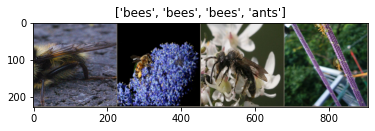

In [44]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Helper Functions

Before we write the code for adjusting the models, lets define a few
helper functions.

**Model Training and Validation Code**


The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
[here](https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958).
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    # A deep copy constructs a new compound object and then, recursively, 
    # inserts copies into it of the objects found in the original.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

**Set Model Parameters’ .requires_grad attribute**


This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [46]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Initialize and Reshape the Networks


Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Finally, notice that inception_v3 requires the input size to be
(299,299), whereas all of the other models expect (224,224).

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.




### Question: where are the pretrained model coeficients of ResNet18 stored? Where is defined the structure of ResNet18? What is this structure?

https://download.pytorch.org/models/resnet18-5c106cde.pth
structure : print(model_ft)
 (fc): Linear(in_features=512, out_features=2, bias=True)

### Question: in the ResNet18 case, why do we do "model_ft.fc = nn.Linear(num_ftrs, num_classes)"?

build the last layer adapted to our number of classes

In [47]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Load Data

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
[here](https://pytorch.org/docs/master/torchvision/models.html).

The loading process is redefined to take into account the input size.



In [48]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Create the Optimizer

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [53]:
# Send the model to GPU
model_ft = model_ft.to(device)

#  Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


## Run Training and Validation Step

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [55]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft, 
                             num_epochs=num_epochs, 
                             is_inception=(model_name=="inception") # 'true' if the model is "inception"
                            )

Epoch 0/14
----------
train Loss: 0.2859 Acc: 0.8730
val Loss: 0.1889 Acc: 0.9281

Epoch 1/14
----------
train Loss: 0.2310 Acc: 0.8770
val Loss: 0.1709 Acc: 0.9281

Epoch 2/14
----------
train Loss: 0.2099 Acc: 0.9057
val Loss: 0.1925 Acc: 0.9346

Epoch 3/14
----------
train Loss: 0.3455 Acc: 0.8361
val Loss: 0.1805 Acc: 0.9412

Epoch 4/14
----------
train Loss: 0.3206 Acc: 0.8648
val Loss: 0.1750 Acc: 0.9346

Epoch 5/14
----------
train Loss: 0.3285 Acc: 0.8730
val Loss: 0.2240 Acc: 0.9281

Epoch 6/14
----------
train Loss: 0.2779 Acc: 0.9016
val Loss: 0.3681 Acc: 0.8824

Epoch 7/14
----------
train Loss: 0.4034 Acc: 0.8443
val Loss: 0.2204 Acc: 0.9281

Epoch 8/14
----------
train Loss: 0.3019 Acc: 0.8648
val Loss: 0.2101 Acc: 0.9216

Epoch 9/14
----------
train Loss: 0.2919 Acc: 0.8934
val Loss: 0.2264 Acc: 0.9412

Epoch 10/14
----------
train Loss: 0.2057 Acc: 0.9180
val Loss: 0.1955 Acc: 0.9346

Epoch 11/14
----------
train Loss: 0.3213 Acc: 0.8443
val Loss: 0.2179 Acc: 0.9216

Ep

## Comparison with Model Trained from Scratch


Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




### Question: complete the following cell to train a ResNet18 network from scratch.

Since there is not that much images the training from scratch is not that good. On top of that the images used to pretraine the network are qui similar to the one of the dataset so the fine tuning is good.

In [57]:
# Initialize the non-pretrained version of the model used for this run

# Complete this cell
feature_extract = True
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft, 
                             num_epochs=num_epochs, 
                             is_inception=(model_name=="inception") # 'true' if the model is "inception"
                            )



Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/14
----------
train Loss: 0.8248 Acc: 0.4959
val Loss: 0.7702 Acc: 0.5425

Epoch 1/14
----------
train Loss: 0.7448 Acc: 0.5205
val Loss: 0.6547 Acc: 0.6078

Epoch 2/14
----------
train Loss: 0.6966 Acc: 0.5410
val Loss: 0.6675 Acc: 0.6013

Epoch 3/14
----------
train Loss: 0.6572 Acc: 0.6148
val Loss: 0.6988 Acc: 0.5686

Epoch 4/14
----------
train Loss: 0.7047 Acc: 0.5615
val Loss: 0.6764 Acc: 0.6013

Epoch 5/14
----------
train Loss: 0.8771 Acc: 0.4795
val Loss: 0.7927 Acc: 0.5163

Epoch 6/14
----------
train Loss: 0.6668 Acc: 0.6311
val Loss: 0.6318 Acc: 0.6536

Epoch 7/14
----------
train Loss: 0.7156 Acc: 0.5902
val Loss: 0.8279 Acc: 0.5425

Epoch 8/14
----------
train Loss: 0.6866 Acc: 0.5984
val Loss: 0.6569 Acc: 0.6013

Epoch 9/14
----------
train Loss: 0.7903 Acc: 0.5492
val Loss: 0.8081 Acc: 0.5229

Epoch 10/14
----------
train Loss: 0.6904 Acc: 0.5861
val Loss: 0.6952 Acc: 0.5621

Epoch 11/14
----------
train Loss: 0.8201 Acc: 

In [17]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

NameError: ignored

### Question: is it preferable to train a neural network with finetuning or from scratch?

### Question: compare the results of finetining with the results of transfer learning.

In [58]:
# Initialize the non-pretrained version of the model used for this run

# Complete this cell
feature_extract = True
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft, 
                             num_epochs=num_epochs, 
                             is_inception=(model_name=="inception") # 'true' if the model is "inception"
                            )

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/14
----------
train Loss: 0.6162 Acc: 0.6598
val Loss: 0.2825 Acc: 0.9085

Epoch 1/14
----------
train Loss: 0.3468 Acc: 0.8525
val Loss: 0.2626 Acc: 0.9085

Epoch 2/14
----------
train Loss: 0.4726 Acc: 0.7828
val Loss: 0.2552 Acc: 0.9020

Epoch 3/14
----------
train Loss: 0.3087 Acc: 0.8607
val Loss: 0.2179 Acc: 0.9216

Epoch 4/14
----------
train Loss: 0.3367 Acc: 0.8484
val Loss: 0.3337 Acc: 0.8889

Epoch 5/14
----------
train Loss: 0.3275 Acc: 0.8607
val Loss: 0.2042 Acc: 0.9216

Epoch 6/14
----------
train Loss: 0.2869 Acc: 0.8770
val Loss: 0.2013 Acc: 0.9281

Epoch 7/14
----------
train Loss: 0.2033 Acc: 0.9262
val Loss: 0.2048 Acc: 0.9346

Epoch 8/14
----------
train Loss: 0.2713 Acc: 0.8852
val Loss: 0.1903 Acc: 0.9542

Epoch 9/14
----------
train Loss: 0.3424 Acc: 0.8730
val Loss: 0.2657 Acc: 0.9216

Epoch 10/14
----------
train Loss: 0.2216 Acc: 0.8975
val Loss: 0.1823 Acc: 0.9346

Epoch 11/14
----------
train Loss: 0.3134 Acc: 

Transfer learning (no change of the weights of the pre trained model) is almost as good as fine tuning. Both transfer learning and fine tuning works well when the images are close to the dataset used for pretrained. "Fine tuning" is a bit more flexible.